In [1]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchinfo import summary
from torch.optim import Adam
import torch.nn as nn
import matplotlib.pyplot as plt

from data import OxfordIIITPet
from model import UNet
from train import train, test

import torchmetrics

c:\Users\navpr\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cuda = torch.cuda.is_available()
print("CUDA Available?", torch.cuda.is_available())
seed = 100
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

CUDA Available? True


In [3]:
# Hyperparameters
batch_size = 64
lr = 0.01
epochs = 20

In [4]:
img_dir = 'data/images/'
mask_dir = 'data/annotations/trimaps/'
transform = transforms.Compose([transforms.ToTensor()])
dataset = OxfordIIITPet(img_dir, mask_dir, transform=transform)
dataset_size = len(dataset)
train_size = int(0.8*dataset_size)
test_size = int(0.2*dataset_size)
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

In [5]:
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

c:\Users\navpr\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:152: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:212.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


Feature batch shape: torch.Size([64, 3, 128, 128])
Labels batch shape: torch.Size([64, 1, 128, 128])


Text(0.5, 1.0, 'Masked Image')

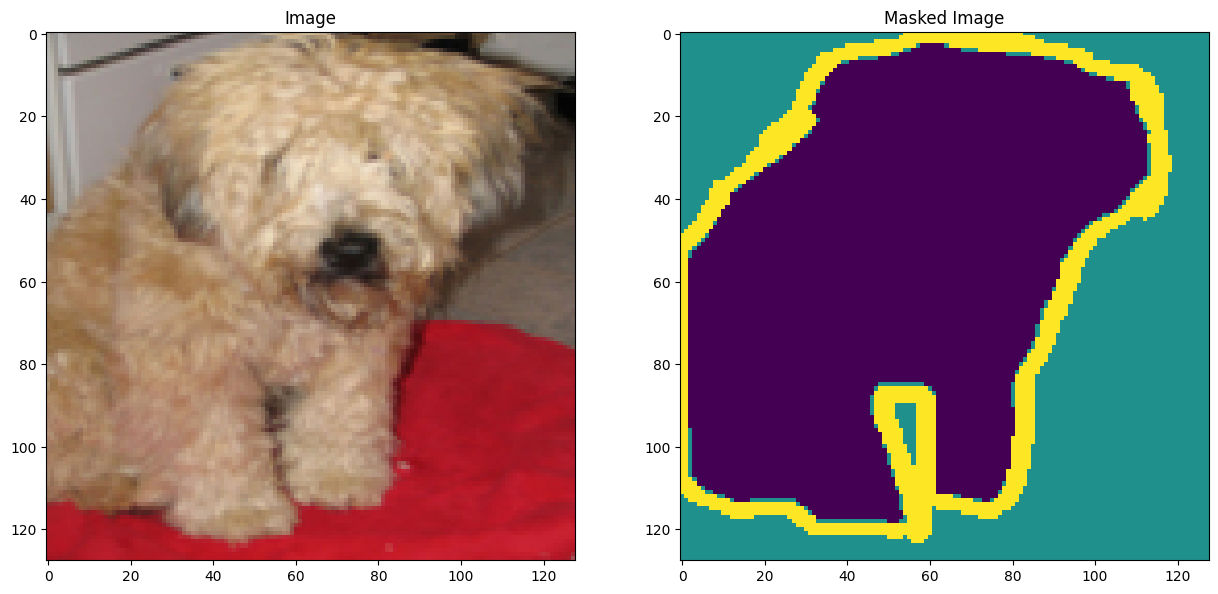

In [6]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0]
mask = train_labels[0].squeeze().numpy()
fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(img.permute(1, 2, 0))
arr[0].set_title('Image')
arr[1].imshow(mask)
arr[1].set_title('Masked Image')

# Training 1

In [7]:
model = UNet(3,3).to(device)
summary(model, (1, 3, 128, 128))

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr)

In [8]:
for epoch in range(1,epochs+1):
    print("EPOCH:\n", epoch)
    train(model, device, train_dataloader, optimizer, criterion)
    test(model, device, test_dataloader, criterion)

EPOCH:
 1


Loss=0.671659529209137 Batch_id=92: 100%|██████████| 93/93 [01:12<00:00,  1.27it/s] 



Test set: Average loss: 0.8168

EPOCH:
 2


Loss=0.589560329914093 Batch_id=92: 100%|██████████| 93/93 [01:14<00:00,  1.25it/s] 



Test set: Average loss: 0.6609

EPOCH:
 3


Loss=0.5102859139442444 Batch_id=92: 100%|██████████| 93/93 [01:13<00:00,  1.27it/s] 



Test set: Average loss: 0.8633

EPOCH:
 4


Loss=0.574970543384552 Batch_id=92: 100%|██████████| 93/93 [01:14<00:00,  1.25it/s]  



Test set: Average loss: 0.5798

EPOCH:
 5


Loss=0.482090562582016 Batch_id=27:  30%|███       | 28/93 [00:22<00:51,  1.26it/s]  


KeyboardInterrupt: 

In [ ]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0]
pred = model(train_features[0].unsqueeze(0).to(device)).detach().cpu()[0]
mask = train_labels[0].squeeze()
fig, arr = plt.subplots(1, 3, figsize=(15, 15))
arr[0].imshow(img.permute(1, 2, 0))
arr[0].set_title('Image')
arr[1].imshow(pred.permute(1, 2, 0))
arr[1].set_title('Pred')
arr[2].imshow(mask)
arr[2].set_title('Masked Image')

# Training 2

In [7]:
def dice_loss(pred, target):
    smooth = 1e-5
    pred = torch.argmax(pred,dim=1)
    # flatten predictions and targets
    pred = pred.view(-1)
    target = target.view(-1)
    
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    
    dice = (2. * intersection + smooth) / (union + smooth)
    
    return 1 - dice   

In [8]:
model = UNet(3,3).to(device)
summary(model, (1, 3, 128, 128))

criterion = dice_loss
optimizer = Adam(model.parameters(), lr=lr)

In [10]:
for epoch in range(1,epochs+1):
    print("EPOCH: ", epoch)
    train(model, device, train_dataloader, optimizer, criterion)
    test(model, device, test_dataloader, criterion)

EPOCH:  1


Loss=0.10057276487350464 Batch_id=92: 100%|██████████| 93/93 [01:19<00:00,  1.17it/s]   



Test set: Average loss: 0.3039

EPOCH:  2


Loss=0.1544637680053711 Batch_id=92: 100%|██████████| 93/93 [00:56<00:00,  1.66it/s]  



Test set: Average loss: 0.1605

EPOCH:  3


Loss=0.13873350620269775 Batch_id=92: 100%|██████████| 93/93 [00:57<00:00,  1.61it/s]



Test set: Average loss: 0.1197

EPOCH:  4


Loss=0.07194864749908447 Batch_id=92: 100%|██████████| 93/93 [00:56<00:00,  1.64it/s]    



Test set: Average loss: -0.0014

EPOCH:  5


Loss=-0.019296765327453613 Batch_id=10:  12%|█▏        | 11/93 [00:07<00:56,  1.46it/s]


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([64, 3, 128, 128])
Labels batch shape: torch.Size([64, 1, 128, 128])


Text(0.5, 1.0, 'Masked Image')

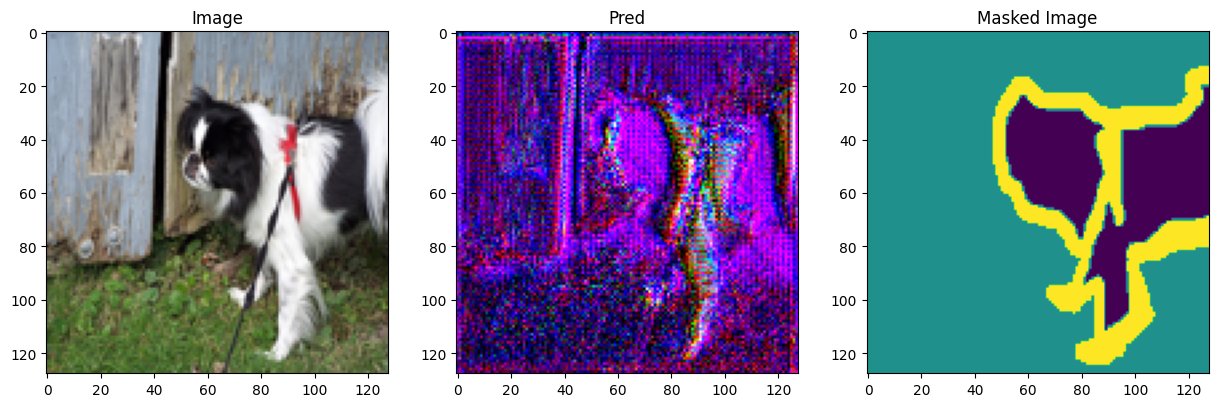

In [ ]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0]
pred = model(train_features[0].unsqueeze(0).to(device)).detach().cpu()[0]
mask = train_labels[0].squeeze()
fig, arr = plt.subplots(1, 3, figsize=(15, 15))
arr[0].imshow(img.permute(1, 2, 0))
arr[0].set_title('Image')
arr[1].imshow(pred.permute(1, 2, 0))
arr[1].set_title('Pred')
arr[2].imshow(mask)
arr[2].set_title('Masked Image')